In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import itertools
%matplotlib inline

In [3]:
def load_imgs(path):
    return [mpimg.imread(e) for e in glob.glob(path)]

vehicle_imgs = load_imgs('train_images/vehicles/*/*.png')
non_vehicle_imgs = load_imgs('train_images/non-vehicles/*/*.png')

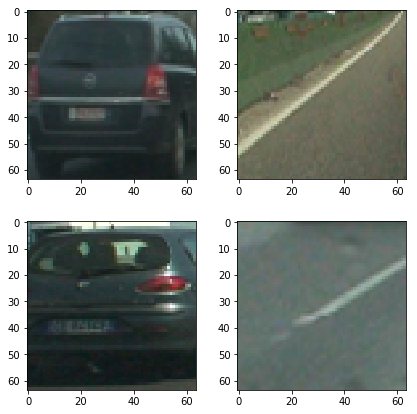

In [170]:
def show_imgs(imgs, titles=None, img_size=(3, 3)):
    n_rows = len(imgs[0])
    n_cols = len(imgs)
    
    figsize = img_size[0] * n_cols, img_size[1] * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.tight_layout()
    
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axs[row, col]
            img = imgs[col][row]
            
            title = '' if titles is None else titles[col]
            
            if isinstance(img, tuple):
                img, title = img
            
            cmap = 'gray' if len(img.shape) == 2 else None
            ax.imshow(img, cmap=cmap)
            ax.set_title(title)

show_imgs([vehicle_imgs[:2], non_vehicle_imgs[:2]])

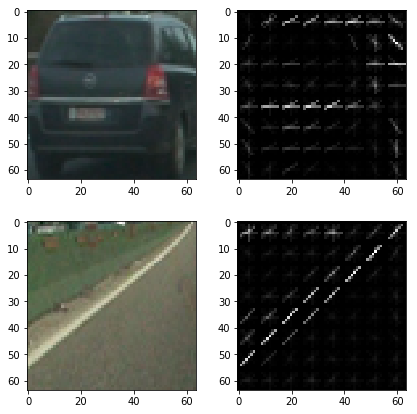

In [167]:
def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, visualise=False, feature_vector=True):
    return hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=feature_vector)

sample_imgs = [vehicle_imgs[0], non_vehicle_imgs[0]]
sample_hog_imgs = [get_hog_features(img[:,:,2], visualise=True)[1] for img in sample_imgs]
show_imgs((sample_imgs, sample_hog_imgs))

## Visualizing color spaces and channels with HOG features

* RGB and HSV show most distinction between vehicle and non-vehicle
* RGB channels seem to be redundant
* HSV channels show distinct features

**Conclusion: Use HSV**

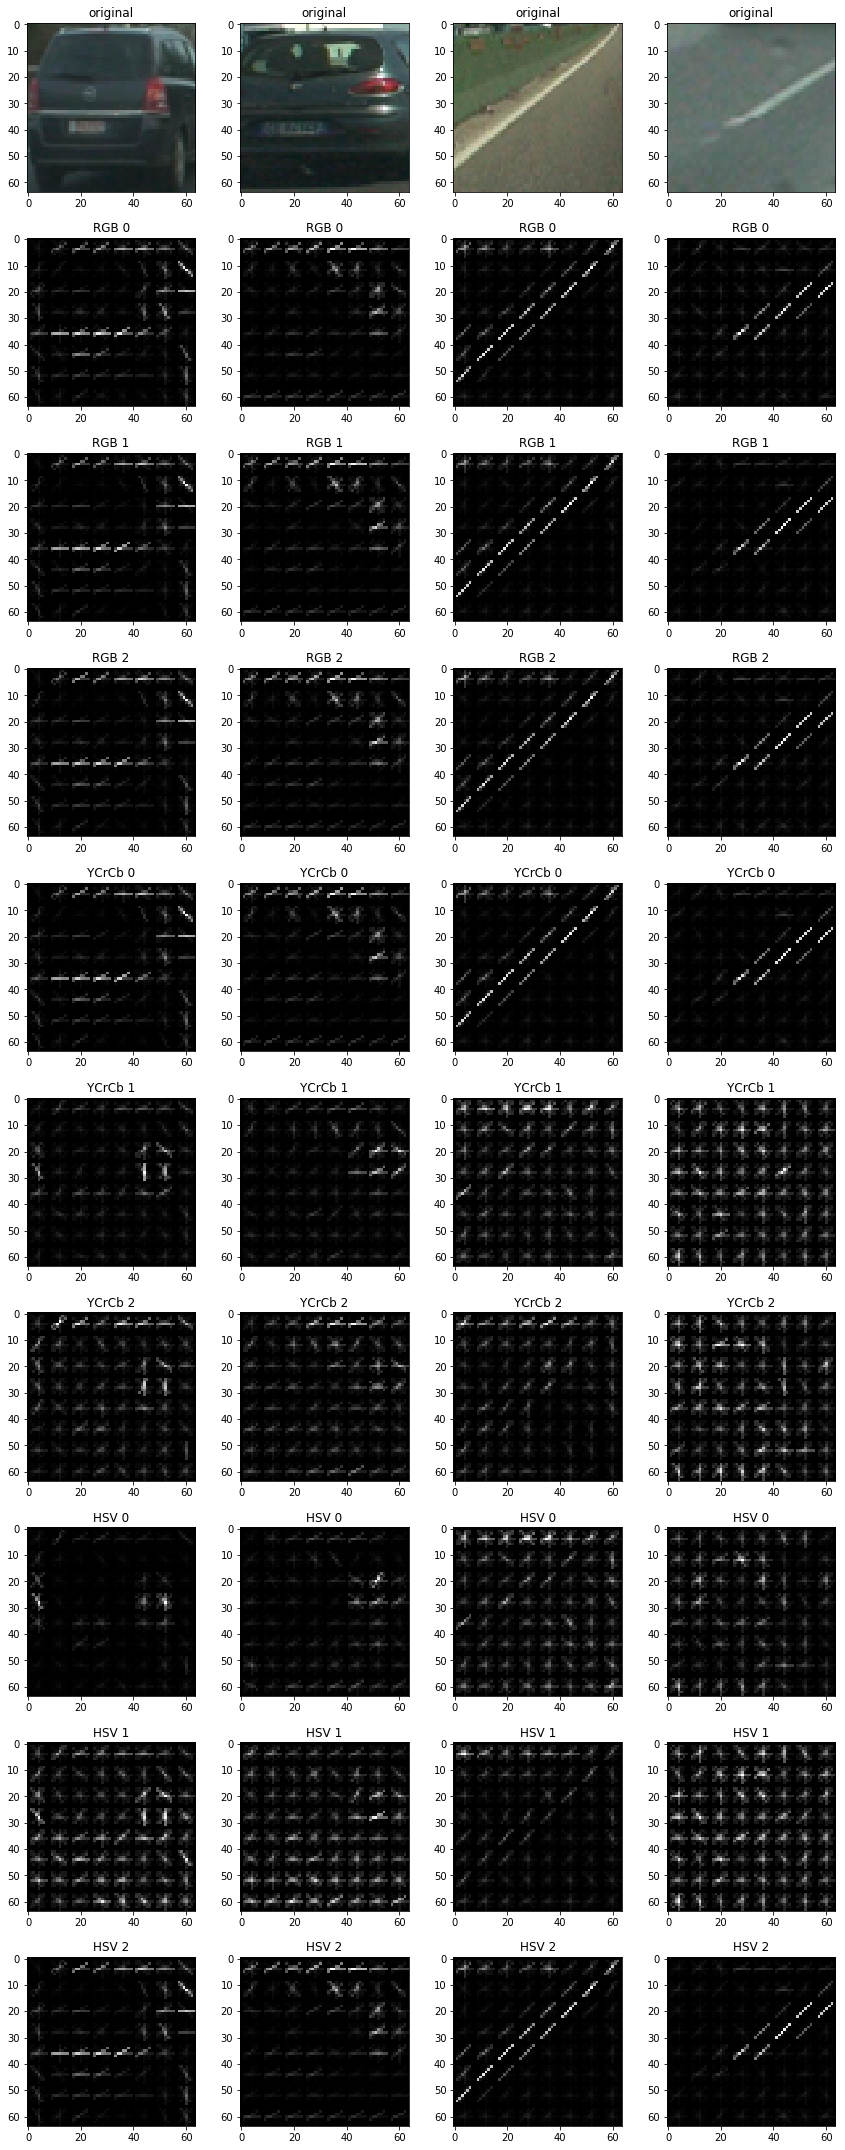

In [168]:
sample_imgs = vehicle_imgs[:2] + non_vehicle_imgs[:2]
spaces = [(None, 'RGB'), (cv2.COLOR_RGB2YCrCb, 'YCrCb'), (cv2.COLOR_RGB2HSV, 'HSV')]
channels = [(0, '0'), (1, '1'), (2, '2')]
output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for space, channel in itertools.product(spaces, channels):
        space_img = img if space[0] is None else cv2.cvtColor(img, space[0])
        channel_img = space_img[:,:,channel[0]]
        hog_img = get_hog_features(channel_img, visualise=True)[1]
        output_imgs.append((hog_img, '{} {}'.format(space[1], channel[1])))
    
    output_img_lists.append(output_imgs)
    
show_imgs(output_img_lists)

## Visualizing HOG parameters

- 8 orientations look a little bit cleaner
- 8 pixels per cell provides enough detail
- not much difference for cells per block

**Conclusion: Use 8 orientations, 8 pixels per cell and 2 cells per block**

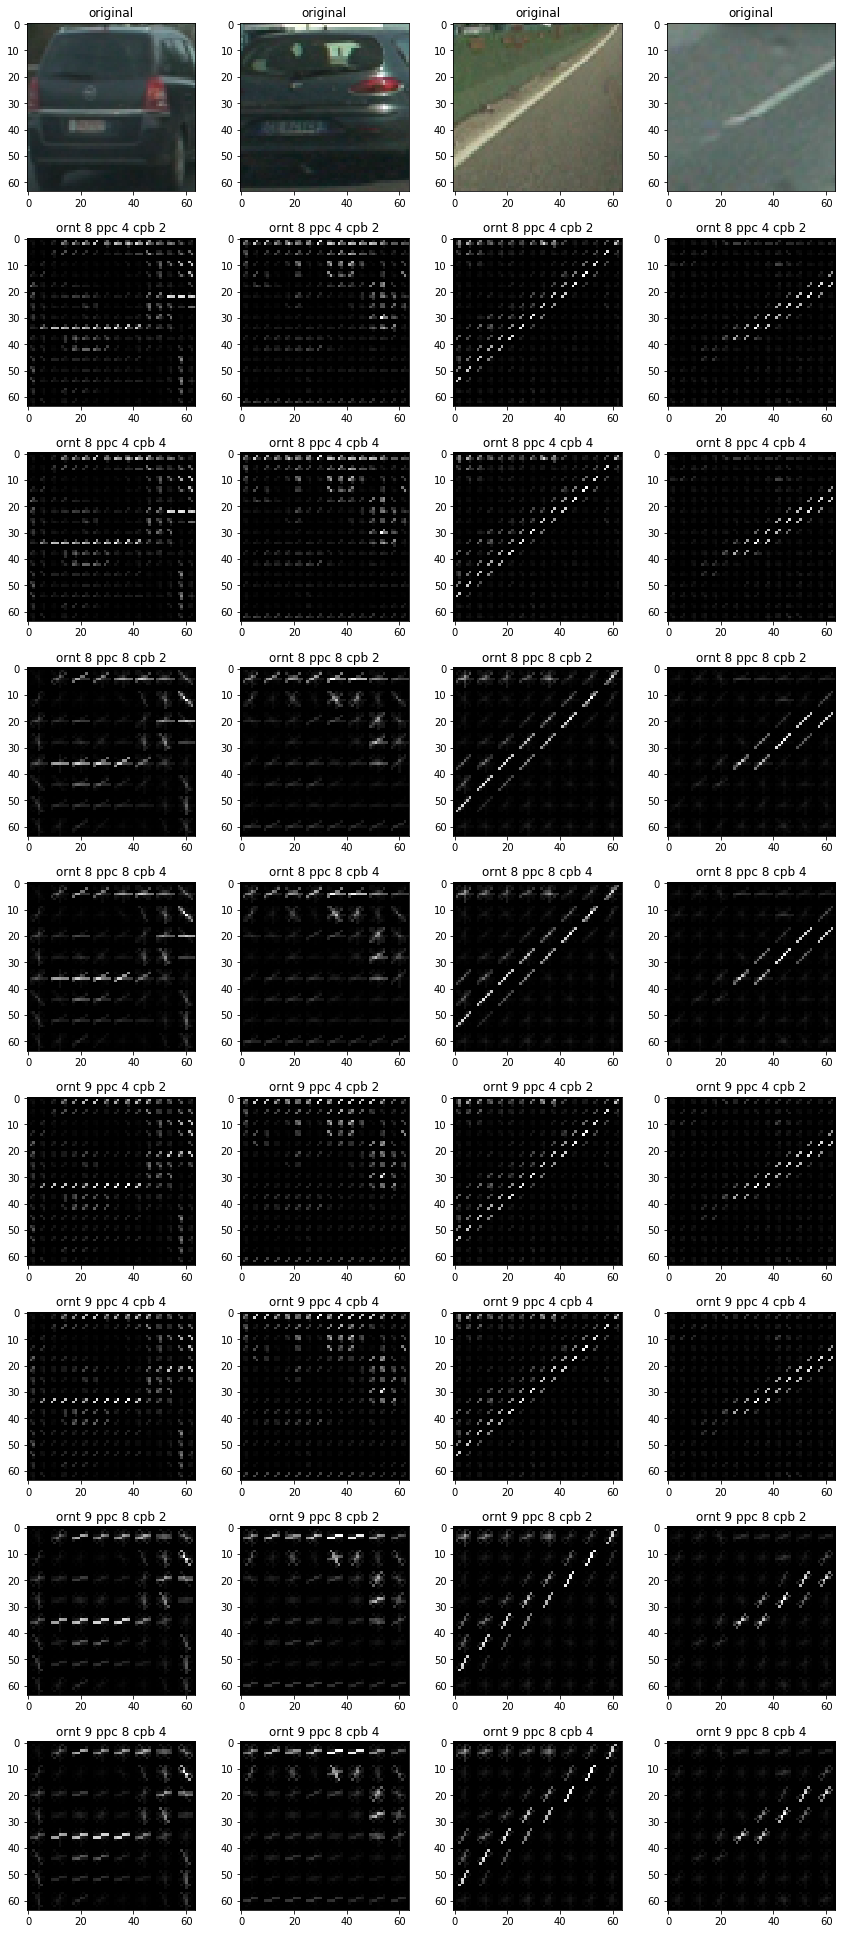

In [169]:
orient_list = [8, 9]
pix_per_cell_list = [4, 8]
cell_per_block_list = [2, 4]

output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for orient, pix_per_cell, cell_per_block  in itertools.product(orient_list, pix_per_cell_list, cell_per_block_list):
        space_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        channel_img = space_img[:,:,2]
        hog_img = get_hog_features(channel_img, orient, pix_per_cell, cell_per_block, visualise=True)[1]
        output_imgs.append((hog_img, 'ornt {} ppc {} cpb {}'
                            .format(orient, pix_per_cell, cell_per_block)))
    
    output_img_lists.append(output_imgs)
    
show_imgs(output_img_lists)

## Training a classifier

In [43]:
def get_hsv_hog_features(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return np.hstack([
        get_hog_features(hsv_img[:,:,0]),
        get_hog_features(hsv_img[:,:,1]),
        get_hog_features(hsv_img[:,:,2])
    ])

vehicle_X = [get_hsv_hog_features(img) for img in vehicle_imgs]
non_vehicle_X = [get_hsv_hog_features(img) for img in non_vehicle_imgs]
X = np.vstack([vehicle_X, non_vehicle_X])
print('X shape ', X.shape)

vehicle_y = np.ones(len(vehicle_imgs))
non_vehicle_y = np.zeros(len(non_vehicle_imgs))
y = np.hstack([vehicle_y, non_vehicle_y])
print('Y shape ', y.shape)

scaler = StandardScaler().fit(features)
scaled_X = scaler.transform(X)
print('Scaled X shape ', scaled_X.shape)

X shape  (17760, 4704)
Y shape  (17760,)
Scaled X shape  (17760, 4704)


In [42]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
clf = LinearSVC()
%time clf.fit(X_train, y_train)
print('Test accuracy {:.3f}'.format(clf.score(X_test, y_test)))

CPU times: user 11.3 s, sys: 224 ms, total: 11.5 s
Wall time: 11.5 s
Test accuracy 0.980


## Sliding window search

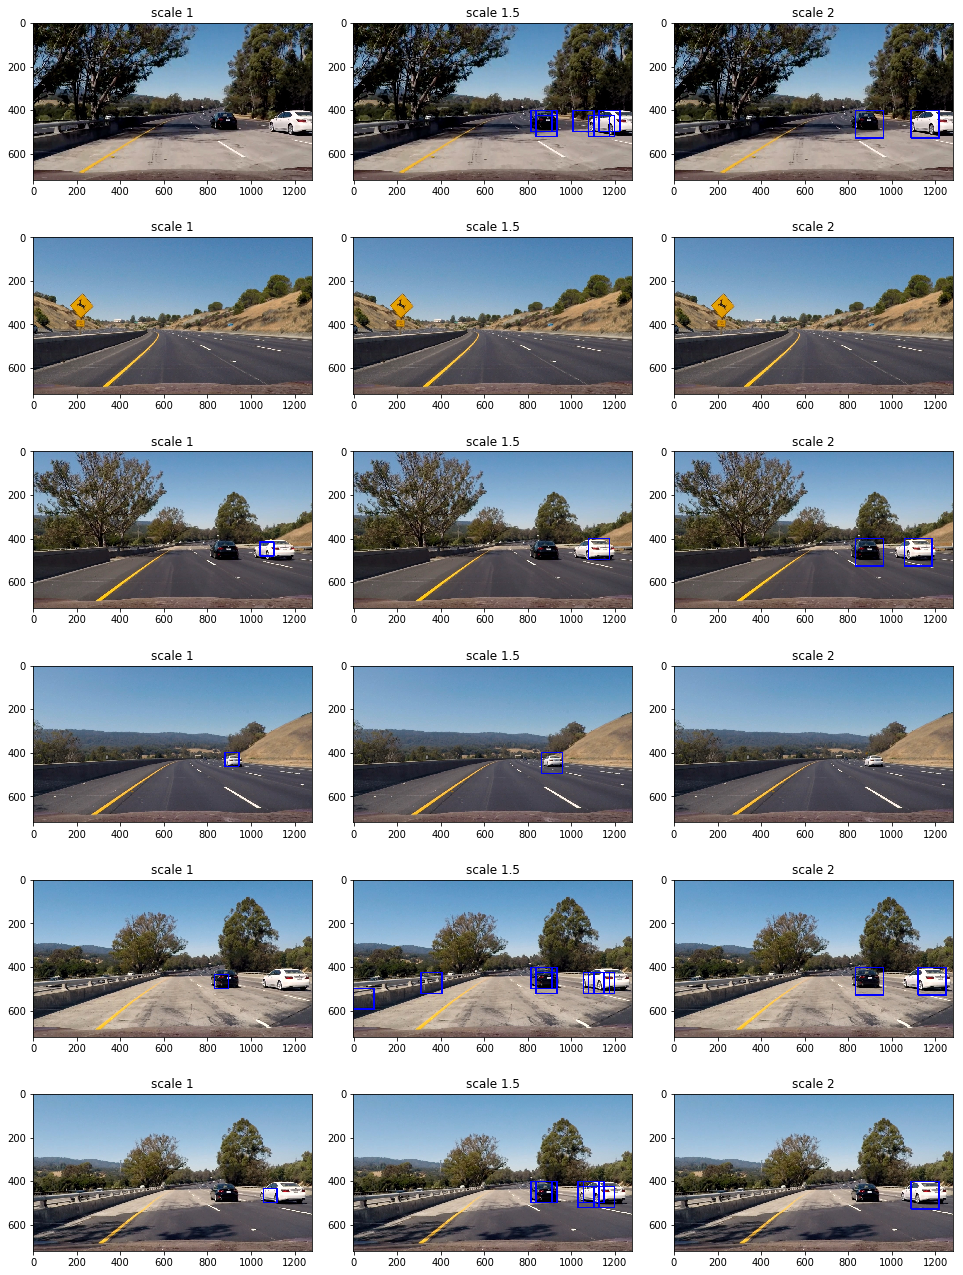

In [186]:
def predict(x):
    scaled_x = scaler.transform(x.reshape(1, -1))
    return clf.predict(scaled_x)     

def sliding_window_search(img, scale=1, y_crop=(400, 656), orient=8, px_per_cell=8, cell_per_block=2, cell_per_step=2, px_per_win=64):
    output_img = np.copy(img)
    cropped_img = img[y_crop[0]:y_crop[1],:,:]
    
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)
    hsv_img = cv2.resize(hsv_img, (int(cropped_img.shape[1]/scale), int(cropped_img.shape[0]/scale)))
        
    hogs = [get_hog_features(hsv_img[:,:,i], orient, px_per_cell, cell_per_block, feature_vector=False) 
            for i in range(3)]
    
    height, width = hsv_img.shape[:2]
    width_block = width//px_per_cell-cell_per_block+1
    height_block = height//px_per_cell-cell_per_block+1 
    feat_per_block = orient*cell_per_block**2
    
    block_per_win = px_per_win//px_per_cell-cell_per_block+1
    x_block_steps = (width_block-block_per_win)//cell_per_step
    y_block_steps = (height_block-block_per_win)//cell_per_step
    
    for x_block in range(x_block_steps):
        for y_block in range(y_block_steps):
            x_cell = x_block*cell_per_step
            y_cell = y_block*cell_per_step
            
            win_hogs = [hog[y_cell:y_cell+block_per_win, x_cell:x_cell+block_per_win].ravel() for hog in hogs]
            win_feats = np.hstack(win_hogs)
            pred = predict(win_feats)
            
            if pred == 1:
                pt1 = int(x_cell*px_per_cell*scale), y_crop[0] + int(y_cell*px_per_cell*scale)
                pt2 = pt1[0]+int(px_per_win*scale), pt1[1]+int(px_per_win*scale)
                cv2.rectangle(output_img, pt1, pt2, (0, 0, 255), 6) 
                
    return output_img
    
test_imgs = load_imgs('test_images/*.jpg')
scales = [1, 1.5, 2]
titles = ['scale {}'.format(scale) for scale in scales]
output_imgs = [[sliding_window_search(img, scale=scale) for img in test_imgs] for scale in scales]
show_imgs(output_imgs, titles=titles, img_size=(4.5, 3))